🔁 Bootstrapping: RandomForest
🔁 Bootstrapping: XGBoost
🔁 Bootstrapping: LASSO


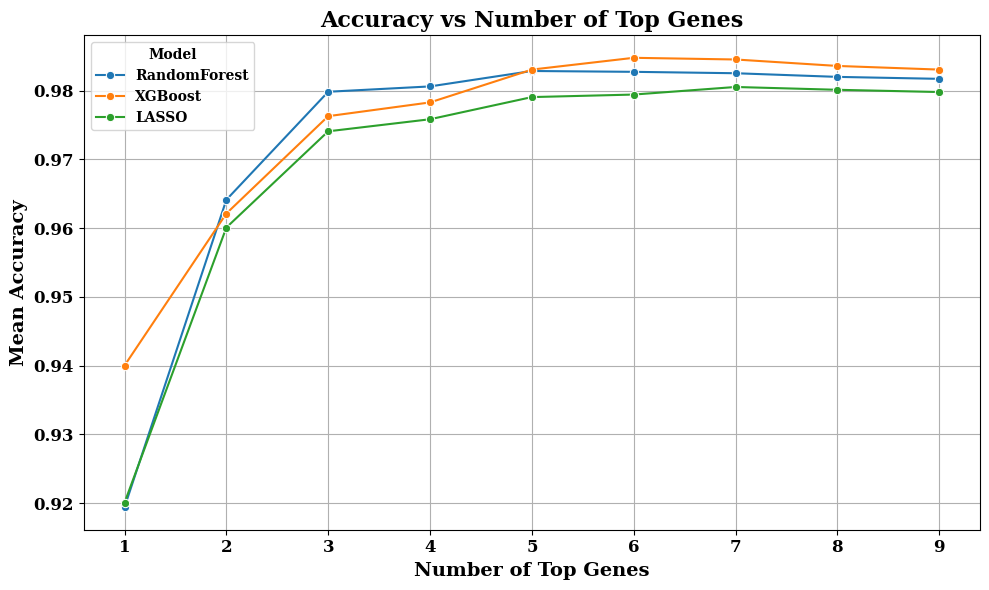

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix
)

# === Suppress warnings from XGBoost and others ===
warnings.filterwarnings("ignore")

# === Load Data ===
expr = pd.read_csv("BRCA_VST_Normalized_Matrix.csv", index_col=0)
meta = pd.read_csv("BRCA_Metadata_Final.csv", index_col=0)
genes_df = pd.read_excel("Common_Genes_BRCA.xlsx", header=None)
selected_genes = genes_df.iloc[:, 0].dropna().str.upper().tolist()

# === Prepare Expression Matrix ===
expr.index = expr.index.str.upper()
expr = expr.loc[expr.index.isin(selected_genes)]
expr = expr.loc[selected_genes]  # preserve order
X = expr.T

# === Prepare Labels ===
meta['Group'] = meta['sample_type'].replace({
    "Solid Tissue Normal": "Normal",
    "Primary Tumor": "Tumor"
})
y = meta.loc[X.index, 'Group'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Models Supporting Feature Importance ===
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LASSO': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
}

# === Create Output Directory ===
os.makedirs("BRCA_ML_Outputs", exist_ok=True)

# === Bootstrap Setup ===
n_bootstraps = 100
sss = StratifiedShuffleSplit(n_splits=n_bootstraps, test_size=0.2, random_state=42)

final_results = []
trend_results = []
importance_df = pd.DataFrame(index=selected_genes)

# === Run for each model ===
for model_name, model in models.items():
    print(f"🔁 Bootstrapping: {model_name}")
    
    model.fit(X_scaled, y_encoded)
    importance = np.abs(model.coef_[0]) if model_name == "LASSO" else model.feature_importances_
    importance_df[model_name] = importance
    
    sorted_indices = np.argsort(importance)[::-1]
    
    for n in range(1, len(selected_genes) + 1):
        top_idx = sorted_indices[:n]
        X_top = X_scaled[:, top_idx]
        
        acc_list = []
        for train_idx, test_idx in sss.split(X_top, y_encoded):
            X_train, X_test = X_top[train_idx], X_top[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            model.fit(X_train, y_train)

            for split, X_set, y_true in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
                y_pred = model.predict(X_set)
                y_proba = model.predict_proba(X_set)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)

                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)
                prec = precision_score(y_true, y_pred)
                rec = recall_score(y_true, y_pred)
                auc = roc_auc_score(y_true, y_proba)
                cm = confusion_matrix(y_true, y_pred)

                TN, FP, FN, TP = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)
                specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
                sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

                final_results.append({
                    'Model': model_name,
                    'Split': split,
                    'NumGenes': n,
                    'Accuracy': acc,
                    'F1 Score': f1,
                    'Precision': prec,
                    'Recall': rec,
                    'ROC AUC': auc,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity
                })
            
            acc_list.append(model.score(X_test, y_test))

        trend_results.append({
            'Model': model_name,
            'NumGenes': n,
            'Accuracy': np.mean(acc_list)
        })

# === Create DataFrames ===
df_full = pd.DataFrame(final_results)
df_trend = pd.DataFrame(trend_results)

# === Filter numeric metrics for aggregation ===
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Sensitivity', 'Specificity']
df_test = df_full[df_full['Split'] == 'Test'][['Model'] + metrics]

agg = df_test.groupby("Model").agg(['mean', 'std']).reset_index()
agg.columns = ['_'.join(col).strip('_') for col in agg.columns.values]
agg = agg.rename(columns={
    'Accuracy_mean': 'Accuracy',
    'F1 Score_mean': 'F1 Score',
    'Precision_mean': 'Precision',
    'Recall_mean': 'Recall',
    'ROC AUC_mean': 'ROC AUC',
    'Sensitivity_mean': 'Sensitivity',
    'Specificity_mean': 'Specificity',
    'Accuracy_std': 'Accuracy_std',
    'F1 Score_std': 'F1 Score_std',
    'Precision_std': 'Precision_std',
    'Recall_std': 'Recall_std',
    'ROC AUC_std': 'ROC AUC_std',
    'Sensitivity_std': 'Sensitivity_std',
    'Specificity_std': 'Specificity_std'
})

# === Save Outputs ===
agg.to_excel("BRCA_ML_Outputs/ML_Performance_Averaged_With_Std.xlsx", index=False)
importance_df.to_excel("BRCA_ML_Outputs/GeneImportance_Scores.xlsx", index=True)
df_trend.to_excel("BRCA_ML_Outputs/Accuracy_vs_TopGenes_Bootstrap.xlsx", index=False)

# === Plot Accuracy Trend ===
# === Plot Accuracy Trend (with serif font and bold axes) ===
plt.figure(figsize=(10, 6))

# Set global font to serif and bold
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Plot using seaborn
sns.lineplot(data=df_trend, x="NumGenes", y="Accuracy", hue="Model", marker="o")

# Customize axes and title
plt.title("Accuracy vs Number of Top Genes", fontsize=16, weight='bold')
plt.xlabel("Number of Top Genes", fontsize=14, weight='bold')
plt.ylabel("Mean Accuracy", fontsize=14, weight='bold')
plt.grid(True)

# Tight layout and save
plt.tight_layout()
plt.savefig("BRCA_ML_Outputs/Accuracy_vs_TopGenes_Bootstrap_HighRes.png", dpi=600)
plt.show()

🔁 Bootstrapping: RandomForest
🔁 Bootstrapping: XGBoost
🔁 Bootstrapping: LASSO


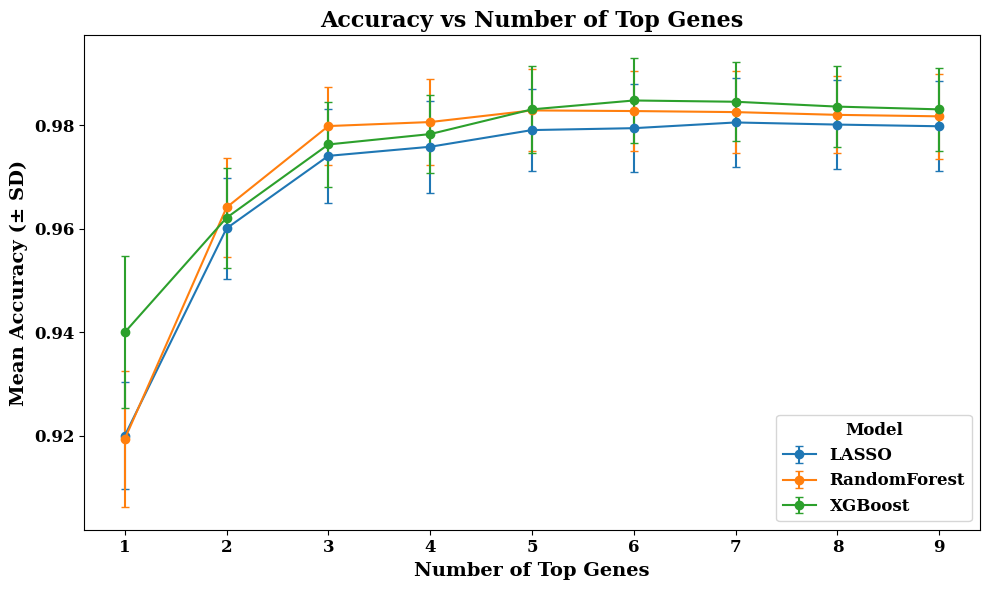

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix
)

# === Suppress warnings from XGBoost and others ===
warnings.filterwarnings("ignore")

# === Load Data ===
expr = pd.read_csv("BRCA_VST_Normalized_Matrix.csv", index_col=0)
meta = pd.read_csv("BRCA_Metadata_Final.csv", index_col=0)
genes_df = pd.read_excel("Common_Genes_BRCA.xlsx", header=None)
selected_genes = genes_df.iloc[:, 0].dropna().str.upper().tolist()

# === Prepare Expression Matrix ===
expr.index = expr.index.str.upper()
expr = expr.loc[expr.index.isin(selected_genes)]
expr = expr.loc[selected_genes]  # preserve order
X = expr.T

# === Prepare Labels ===
meta['Group'] = meta['sample_type'].replace({
    "Solid Tissue Normal": "Normal",
    "Primary Tumor": "Tumor"
})
y = meta.loc[X.index, 'Group'].values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# === Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Models Supporting Feature Importance ===
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42),
    'LASSO': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000, random_state=42)
}

# === Create Output Directory ===
os.makedirs("BRCA_ML_Outputs", exist_ok=True)

# === Bootstrap Setup ===
n_bootstraps = 100
sss = StratifiedShuffleSplit(n_splits=n_bootstraps, test_size=0.2, random_state=42)

final_results = []
trend_results = []
importance_df = pd.DataFrame(index=selected_genes)

# === Run for each model ===
for model_name, model in models.items():
    print(f"🔁 Bootstrapping: {model_name}")
    
    # Fit once on all features for importance ranking
    model.fit(X_scaled, y_encoded)
    importance = np.abs(model.coef_[0]) if model_name == "LASSO" else model.feature_importances_
    importance_df[model_name] = importance
    
    sorted_indices = np.argsort(importance)[::-1]
    
    for n in range(1, len(selected_genes) + 1):
        top_idx = sorted_indices[:n]
        X_top = X_scaled[:, top_idx]
        
        acc_list = []
        for train_idx, test_idx in sss.split(X_top, y_encoded):
            X_train, X_test = X_top[train_idx], X_top[test_idx]
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            model.fit(X_train, y_train)

            for split, X_set, y_true in [('Train', X_train, y_train), ('Test', X_test, y_test)]:
                y_pred = model.predict(X_set)
                y_proba = model.predict_proba(X_set)[:, 1] if hasattr(model, "predict_proba") else np.zeros_like(y_pred)

                acc = accuracy_score(y_true, y_pred)
                f1 = f1_score(y_true, y_pred)
                prec = precision_score(y_true, y_pred)
                rec = recall_score(y_true, y_pred)
                auc = roc_auc_score(y_true, y_proba)
                cm = confusion_matrix(y_true, y_pred)

                TN, FP, FN, TP = cm.ravel() if cm.shape == (2, 2) else (0, 0, 0, 0)
                specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
                sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0

                final_results.append({
                    'Model': model_name,
                    'Split': split,
                    'NumGenes': n,
                    'Accuracy': acc,
                    'F1 Score': f1,
                    'Precision': prec,
                    'Recall': rec,
                    'ROC AUC': auc,
                    'Sensitivity': sensitivity,
                    'Specificity': specificity
                })
            
            acc_list.append(model.score(X_test, y_test))

        trend_results.append({
            'Model': model_name,
            'NumGenes': n,
            'Accuracy': np.mean(acc_list)
        })

# === Create DataFrames ===
df_full = pd.DataFrame(final_results)
df_trend = pd.DataFrame(trend_results)

# === Filter numeric metrics for aggregation ===
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall', 'ROC AUC', 'Sensitivity', 'Specificity']
df_test = df_full[df_full['Split'] == 'Test'][['Model'] + metrics]

agg = df_test.groupby("Model").agg(['mean', 'std']).reset_index()
agg.columns = ['_'.join(col).strip('_') for col in agg.columns.values]
agg = agg.rename(columns={
    'Accuracy_mean': 'Accuracy',
    'F1 Score_mean': 'F1 Score',
    'Precision_mean': 'Precision',
    'Recall_mean': 'Recall',
    'ROC AUC_mean': 'ROC AUC',
    'Sensitivity_mean': 'Sensitivity',
    'Specificity_mean': 'Specificity',
    'Accuracy_std': 'Accuracy_std',
    'F1 Score_std': 'F1 Score_std',
    'Precision_std': 'Precision_std',
    'Recall_std': 'Recall_std',
    'ROC AUC_std': 'ROC AUC_std',
    'Sensitivity_std': 'Sensitivity_std',
    'Specificity_std': 'Specificity_std'
})

# === Save Outputs ===
agg.to_excel("BRCA_ML_Outputs/ML_Performance_Averaged_With_Std.xlsx", index=False)
importance_df.to_excel("BRCA_ML_Outputs/GeneImportance_Scores.xlsx", index=True)
df_trend.to_excel("BRCA_ML_Outputs/Accuracy_vs_TopGenes_Bootstrap.xlsx", index=False)

# === Plot Accuracy Trend with Error Bars (no grid) ===
plt.figure(figsize=(10, 6))

# serif + bold styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Compute mean & std per Model and NumGenes from the bootstrap results (Test split)
df_err = (
    df_full[df_full['Split'] == 'Test']
    .groupby(['Model', 'NumGenes'])['Accuracy']
    .agg(['mean', 'std'])
    .reset_index()
)

# Plot error bars
for model in df_err['Model'].unique():
    sub = df_err[df_err['Model'] == model]
    plt.errorbar(
        sub['NumGenes'], sub['mean'], yerr=sub['std'],
        marker='o', capsize=3, label=model, linewidth=1.5
    )

plt.title("Accuracy vs Number of Top Genes", fontsize=16, weight='bold')
plt.xlabel("Number of Top Genes", fontsize=14, weight='bold')
plt.ylabel("Mean Accuracy (± SD)", fontsize=14, weight='bold')

# Remove grid
plt.grid(False)

plt.legend(title="Model", fontsize=12, title_fontsize=12)
plt.tight_layout()
plt.savefig("BRCA_ML_Outputs/Accuracy_vs_TopGenes_Bootstrap_WithErrorBars.png", dpi=600)
plt.show()